# Аналіз та обробка великих даних

Ю.С. Процик. Курс лекцій

# Тема 2. Розподілена файлова система Hadoop

### План

1. [Концепції та архітектурні рішення](#1.-Концепції-та-архітектурні-рішення)
2. [NameNode](#2.-NameNode)
3. [DataNode](#3.-DataNode)
4. [Secondary NameNode](#4.-Secondary-NameNode)
5. [Читання та запис даних в HDFS](#5.-Читання-та-запис-даних-в-HDFS)

**Hadoop Distributed File System (HDFS)** – це розподілена файлова система, яка забезпечує високошвидкісний доступ до даних і є одним з ключових компонентів платформи Hadoop.

HDFS є ієрархічною файловою системою з блочною структурою, де кожен файл розділений на блоки попередньо визначеного розміру. Ці блоки зберігаються в кластері з однієї або кількох машин. Архітектура Apache Hadoop HDFS відповідає архітектурі Master/Slave (головний/підлеглий), де кластер складається з одного **NameNode** (Master node), а всі інші вузли є **DataNodes** (Slave nodes). HDFS можна розгорнути на широкому спектрі машин, які підтримують Java. Хоча на одній машині можна запустити кілька DataNodes, але на практиці ці DataNodes розподілені по різних машинах.

Отже, основними елементами HDFS є:
- **NameNode** – головний вузол, який виконує функції підтримки каталогів, файлів та управління блоками даних, розподіленими між вузлами кластера;
- **DataNode** – підлеглий вузол, що забезпечує фізичний простір для зберігання, обробляє запити читання/запису з головного вузла.
- **Secondary NameNode** – резервний екземпляр для NameNode, що працює на іншому вузлі кластера.

### 1. Концепції та архітектурні рішення 

Основні концепції, закладені при проектуванні HDFS, і архітектурні рішення, застосовувані для реалізації цих концепцій:

**Обсяг даних.** HDFS не повинна мати досяжних в найближчому майбутньому обмежень на обсяг збережених даних.

*Архітектурне рішення*:

HDFS зберігає файли поблочно. Блоки в HDFS розподілені між вузлами даних обчислювального кластера. Всі блоки (крім останнього блоку файлу) мають однаковий розмір, крім того блок може бути розміщений на декількох вузлах.

**Відмовостійкість.** HDFS розцінює вихід з ладу вузла даних як норму, а не як виняток.

*Архітектурні рішення*:

1. Для забезпечення відмовостійкості всі дані в HDFS реплікуються налаштовувану кількість разів.

2. Захист від копіювання пошкоджених даних вирішено за допомогою зберігання контрольних сум в окремому прихованому файлі.

3. Копіювання метаданих за допомогою вторинного вузла імен.

**Автодіагностика**. Діагностика справності вузлів в Hadoop-кластері не повинна вимагати додаткового адміністрування.

*Архітектурні рішення*:

1. Кожен вузол даних через певні інтервали часу відправляє діагностичні повідомлення вузлу імен.

2. Логування операцій над файлами в спеціальний журнал вузла імен.

**Продуктивність**. У квітні 2008 року Hadoop побив світовий рекорд продуктивності в стандартизованому тесті продуктивності по сортуванню даних – 1 Тбайт був оброблений за 309 сек. на кластері з 910 вузлів.

*Архітектурні рішення*:

1. Принцип "один раз записати – багато разів прочитати" (Write-once and read-many, WORM) повністю звільняє систему від блокувань типу "запис-читання". Позбутися від конфліктів множинного запису архітектори вирішили, дозволивши запис у файл в один час тільки одному процесу.

2. HDFS оптимізований під потокову передачу даних.

3. Зниження навантаження на канали передачі даних (а саме ці канали найчастіше є вузьким місцем у розподілених середовищах), а також більш раціональне використання простору на жорстких дисках дозволило досягти стиснення даних.

4. Реплікація відбувається в асинхронному режимі.

5. Зберігання всіх метаданих вузла "NameNode" в оперативній пам'яті.

### 2. NameNode

В повністю сконфігурованому кластері під "запуском Hadoop" розуміється запуск набору демонів або резидентних програм на різних мережевих серверах. Кожен демон відіграє свою роль; деякі запускаються тільки на одному сервері, інші – на декількох.

**Демон** (англ. daemon) — сервіс Unix та Unix-подібних операційних систем, що працює у фоновому режимі без прямого спілкування з користувачем.

Розглянемо більш детально демони **NameNode**, **DataNode** та **Secondary NameNode** і їх роль у фреймворку Hadoop.

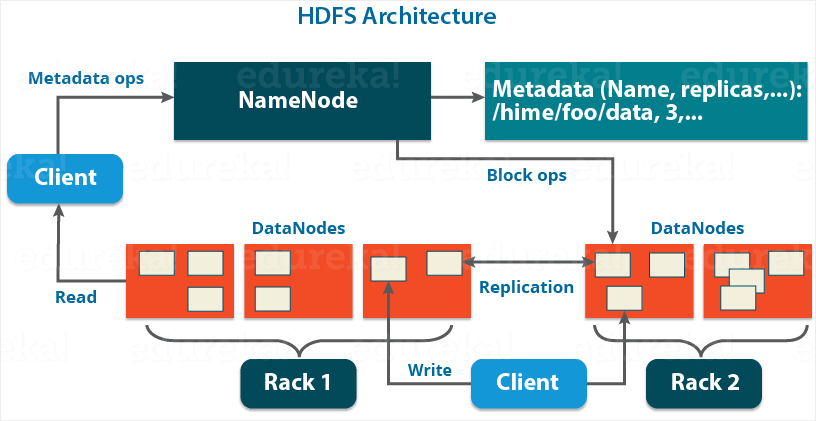

**NameNode** представляє собою головний демон HDFS, який розподіляє низькорівневі задачі введення/виведення між підлеглими демонами DataNode. NameNode – це диспетчер HDFS; він веде облік розбиття файлів на блоки, зберігає інформацію про те, на яких вузлах ці блоки знаходяться, і стежить за загальним станом розподіленої файлової системи.
Для демона NameNode характерне високе споживання пам'яті та великий обсяг операцій введення/виведення. Тому на сервері, де
працює NameNode, не зберігаються дані користувача і не виконуються обчислення, пов'язані з MapReduce-програмами, що дозволяє зменшити навантаження на машину. Це означає, що сервер NameNode не дублюється, як, наприклад, DataNode. Таким чином, важливість NameNode має зворотний бік — його відмова призводить до відмови системи загалом. При відмові — програмній або апаратній — вузла, на якому працює будь-який інший демон, кластер Hadoop, швидше за все, успішно продовжить роботу, а той вузол, що відмовив, можна буде швидко перезапустити.

*Функції NameNode*:

- Головний демон, який підтримує та керує DataNodes (підлеглими вузлами).

- Записує метадані всіх файлів, що зберігаються в кластері, наприклад розташування збережених блоків, розмір файлів, дозволи, ієрархію тощо. Є два файли, пов’язані з метаданими:
    - *FsImage*: містить повний стан простору імен файлової системи з моменту старту NameNode.
    - *EditLogs*: містить усі останні зміни, внесені до файлової системи, що не увійшли в останній *FsImage*.

- Записує кожну зміну метаданих файлової системи. Наприклад, якщо файл буде видалено в HDFS, NameNode негайно запише це в *EditLog*.

- Регулярно отримує Heartbeat і звіт про блокування від усіх DataNodes у кластері, щоб переконатися, що DataNodes працюють.

- Зберігає записи про всі блоки в HDFS і в яких вузлах ці блоки розташовані.

- Відповідає за коефіцієнт реплікації всіх блоків.

- У  разі збою DataNode, вибирає нові DataNodes для нових реплік, регулює використання диску та керує трафіком зв’язку до DataNodes.

### 3. DataNode

На будь-якій підлеглій машині в кластері працює демон **DataNode**, на який покладено основну роботу розподіленої файлової системи – зчитування та запис блоків HDFS у фізичні файли, що знаходяться у локальній файловій системі. Коли клієнт хоче прочитати або записати HDFS-файл, демон NameNode повідомляє йому, на якому вузлі DataNode знаходиться кожний блок файлу. Далі клієнт безпосередньо спілкується з демонами DataNode, працюючи з локальними файлами, які відповідають блокам. Крім того, демон DataNode може взаємодіяти з іншими такими самими демонами, здійснюючи реплікацію блоків даних задля забезпечення резервування.

Демони DataNode періодично передають NameNode інформацію про стан. На стадії ініціалізації кожен DataNode повідомляє NameNode про блоки, які зберігаються на ньому в даний момент. В подальшому демони DataNode продовжують взаємодія з NameNode, передаючи інформацію про локальні зміни та отримуючи інструкції про створення, переміщення та видалення блоків з локального диска.

*Функції DataNode*:

- Підлеглі демони або процеси, які виконуються на кожній підпорядкованій машині.

- Фактичні дані зберігаються на DataNodes.

- DataNodes виконують низькорівневі запити на читання та запис від клієнтів файлової системи.

- Періодично надсилають сигнали до NameNode, щоб повідомити про загальний стан HDFS, за замовчуванням ця частота рівна 3 секундам.

### 4. Secondary NameNode

**Secondary NameNode** (SNN) – це допоміжний демон, який займається моніторингом стану кластера HDFS. У кластері може бути тільки один SNN, і зазвичай для нього виділяється спеціальний сервер. На цьому сервері не може працювати DataNode. Від NameNode демон SNN відрізняється тим, що не отримує та не протоколює інформацію про зміни HDFS у режимі реального часу. Натомість він взаємодіє з NameNode з метою створення миттєвих знімків (контрольних точок) метаданих HDFS; інтервал часу між операціями створення контрольних точок визначається конфігурацією кластера.

Контрольні точки, створювані SNN, дозволяють зменшити час простою та звести до мінімуму втрату даних у разі відмови NameNode. Тим не менш, відмова NameNode вимагає втручання з боку людини – необхідно переконфігурувати кластер так, щоб вузол SNN
став основним вузлом NameNode.

*Функції Secondary NameNode*:

- Вторинний NameNode — це той, який постійно зчитує всі файлові системи та метадані з оперативної пам’яті NameNode і записує їх на жорсткий диск або файлову систему.

- Відповідає за об’єднання *EditLogs* із *FsImage* з NameNode. 

- Завантажує *EditLogs* із NameNode через регулярні проміжки часу та об'єднує з *FsImage*. Новий *FsImage* копіюється назад до NameNode та використовується під час наступного запуску NameNode.

### 5. Читання та запис даних в HDFS

#### Блоки

Дані в HDFS розкидані по DataNodes як блоки. Що таке блок і як він формується?

**Блоки** — це не що інше, як найменше неперервне місце на жорсткому диску, де зберігаються дані. Загалом, у будь-якій файловій системі дані зберігаються як набір блоків. Подібним чином HDFS зберігає кожен файл у вигляді блоків, які розкидані по всьому кластеру Apache Hadoop. Стандартний розмір кожного блоку в Apache Hadoop 2 становить 128 МБ, який можна налаштувати відповідно до вимог.

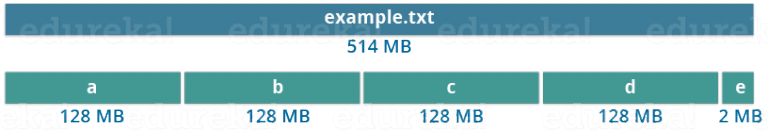


#### Керування реплікаціями

Для забезпечення відмовостійкості блоки в HDFS реплікуються. 

**Реплікація даних в HDFS** – це процес синхронізації вмісту декількох копій файлового блоку, коли його вміст з одного DataNode копіюється на інші вузли даних, щоб запобігти втраті даних у разі збою будь-якого сховища.

Коефіцієнт реплікації за замовчуванням становить 3 та його можна налаштувати. На рисунку нижче відображено, як кожен блок реплікується три рази та зберігається на різних DataNodes. 

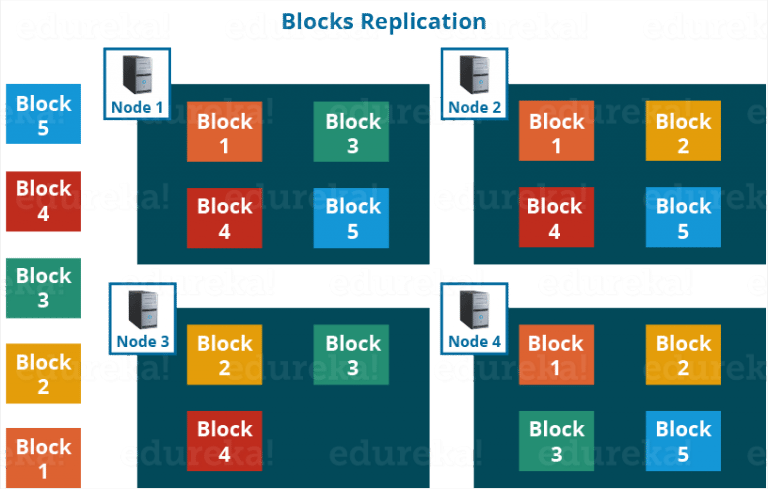

Таким чином, якщо користувач зберігає файл розміром 128 МБ у HDFS із використанням конфігурації за замовчуванням, сумарно буде зайнято 384 МБ (3 * 128 МБ), оскільки блоки будуть репліковані тричі, і кожна репліка розміщуватиметься на іншому DataNode. 

*Примітка*: NameNode періодично збирає інформацію про блоки від DataNode, щоб підтримувати коефіцієнт реплікації. Таким чином, щоразу, коли виникає ситуація надмірною або недостатньою кількості реплік для якогось блоку, NameNode їх відповідно видаляє або додає. 

#### Механізм Rack Awareness

Для маленьких кластерів, де всі сервери з'єднані одним свічем, існує два рівні локалізації: *on-machine* і *off-machine*. Завантажуючи дані з DataNode локального диска в HDFS, NameNode призначить одну копію для відправлення в локальний DataNode, і вибиратиме дві інші машини навмання з кластера.

Для більших збірок Hadoop, що охоплюють кілька стійок, важливо переконатися, що існують копії даних у інших стійках. 

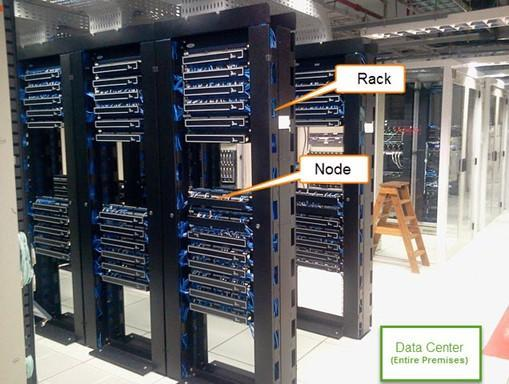

NameNode гарантує, що всі репліки не зберігатимуться у одній стійці. Він використовує вбудований алгоритм **Rack Awareness**, щоб зменшити затримку, а також забезпечити відмовостійкість. Нижче наведено схему, що зображує роботу цього алгоритму.

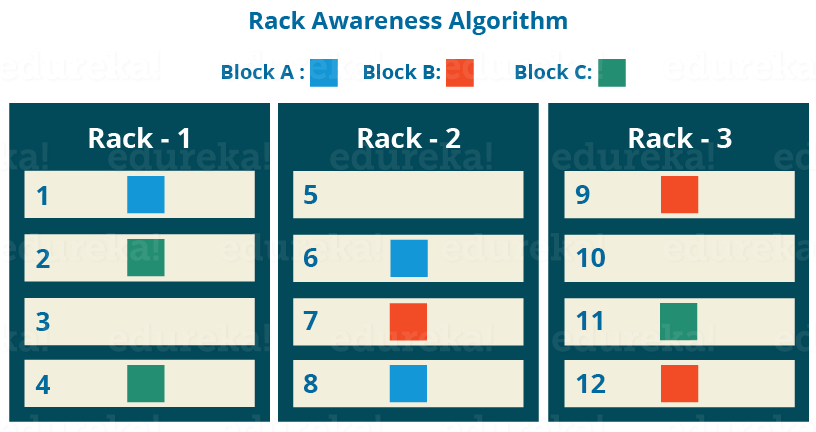

Враховуючи, що коефіцієнт реплікації дорівнює 3, алгоритм Rack Awareness говорить, що перша репліка блоку буде збережена в локальній стійці, а наступні дві репліки будуть збережені на різних вузлах іншої (віддаленої) стійки. Якщо реплік більше, то решту буде розміщено на випадкових вузлах даних за умови, що не більше двох реплік (якщо це можливо) розміщено в одній стійці.

Ось так виглядає справжній виробничий кластер Hadoop. Тут є декілька стійок, заповнених DataNodes:

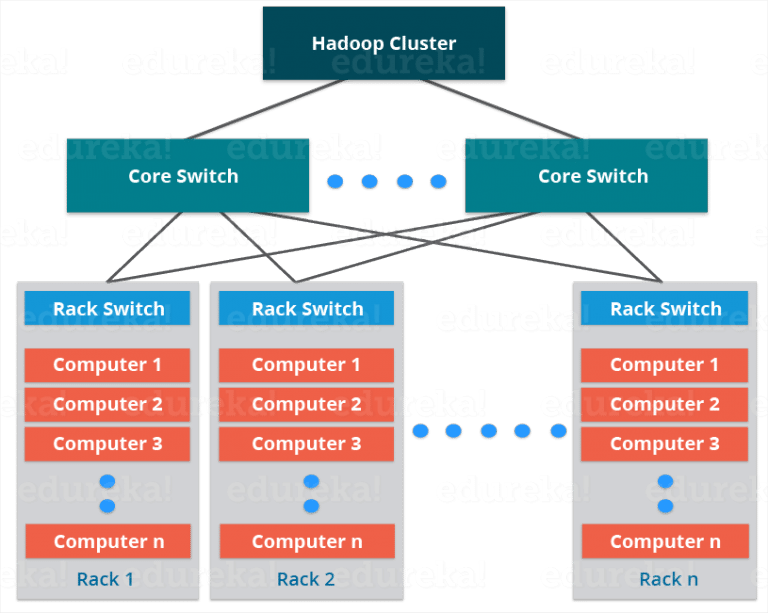

*Переваги Rack Awareness*:

**Покращення продуктивності мережі**. Зв’язок між вузлами, розташованими у різних стійках, здійснюється через комутатор. Загалом пропускна здатність мережі між машинами в одній стійці буде більшою, ніж між машинами, які знаходяться в різних стійках. Rack Awareness допомагає зменшити трафік запису між різними стійками, забезпечуючи, таким чином, кращу продуктивність запису. Крім того, збільшується продуктивність читання, оскільки використовується пропускна здатність декількох стійок.

**Запобігання втраті даних**. Не потрібно турбуватися про дані, навіть якщо вся стійка вийде з ладу через несправність комутатора або збій живлення.

#### Архітектура читання/запису HDFS

Як зазначалося раніше, HDFS дотримується філософії "Один раз запиши – багато разів прочитай». Отже, не можна редагувати файл, який вже зберігається в HDFS, але можна додати нові дані, повторно його відкривши.

**Запис в HDFS**

Припустимо, що клієнт HDFS хоче записати файл *example.txt* розміром 248 МБ.

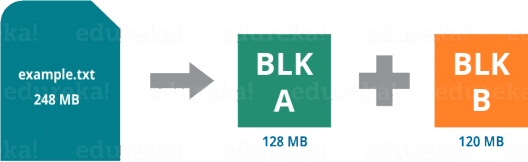

Будемо вважати, що розмір системного блоку налаштовано на 128 МБ (за замовчуванням). Отже, клієнт розділить файл *example.txt* на 2 блоки – один 128 МБ (блок A), а інший 120 МБ (блок B). 

Процес запису даних у HDFS виглядає наступним чином:

- Спочатку клієнт HDFS звернеться до NameNode для запиту на запис двох блоків (блок A та блок B).

- Потім NameNode надасть клієнту дозвіл на запис і надасть IP-адреси DataNodes, куди зрештою будуть скопійовані блоки файлів.

    Вибір IP-адрес DataNodes є випадковим на основі доступності, коефіцієнта реплікації та Rack Awareness. Оскільки коефіцієнт реплікації рівний 3, то для кожного блоку NameNode надаватиме клієнту список з 3 IP-адрес DataNodes. Список буде унікальним для кожного блоку. 
    Припустимо, NameNode надав клієнту такі списки IP-адрес: 
    - Для блоку A: `{IP-адреса DataNode 1, IP-адреса DataNode 4, IP-адреса DataNode 6}`
    
    - Для блоку B: `{IP-адреса DataNode 3, IP-адреса DataNode 7, IP-адреса DataNode 9}`
    
- Кожен блок буде скопійовано на три різні вузли даних. 

    Процес копіювання даних відбуватиметься в три етапи:

    1. Налаштування конвеєра (papeline)

    2. Потік даних і реплікація

    3. Завершення роботи конвеєра 

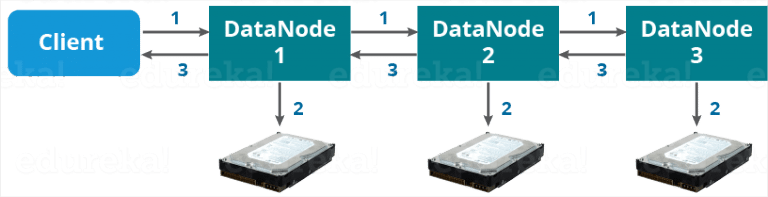


*Налаштування конвеєра*:

Перед записом блоків клієнт підтверджує чи готові DataNodes, присутні в списках IP-адрес, приймати дані чи ні. Роблячи це, клієнт створює конвеєр для кожного з блоків, підключаючи окремі DataNodes у відповідному списку для цього блоку. Давайте розглянемо блок A. Список DataNodes, наданий NameNode, такий:
`{IP of DataNode 1, IP of DataNode 4, IP of DataNode 6}` 

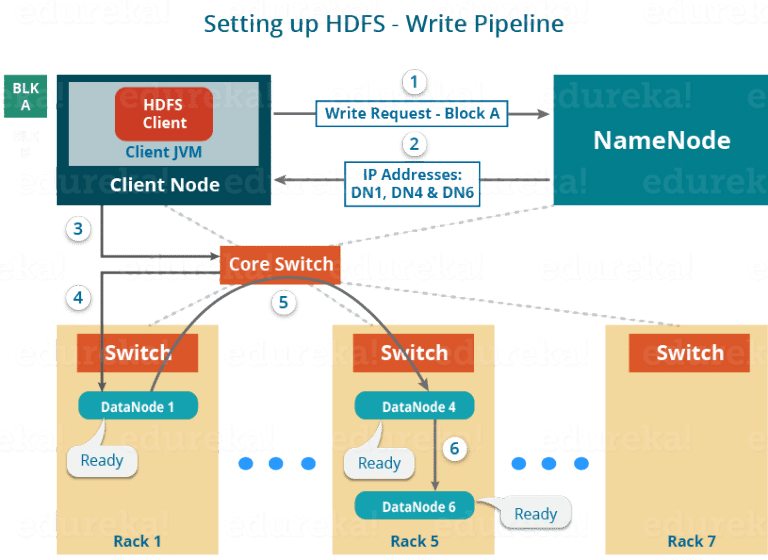

Отже, щоб створити конвеєр для блоку A будуть виконані такі кроки:

- Клієнт вибере перший DataNode у списку (IP-адреси DataNode для блоку A), який є DataNode 1, і встановить TCP/IP з’єднання.

- Повідомить DataNode 1, щоб він був готовий прийняти блок та надасть йому IP-адреси наступних двох вузлів даних (4 і 6), куди блок має бути реплікований.

- DataNode 1 підключиться до DataNode 4, повідомить його про готовність прийняти блок і надасть йому IP-адресу DataNode 6. Потім DataNode 4 повідомить DataNode 6 про готовність отримати дані.

- Далі підтвердження готовності відбуватиметься у зворотній послідовності, тобто від DataNode 6 до 4, а потім до 1.

- Нарешті DataNode 1 повідомить клієнта, що всі DataNodes готові, і між клієнтом, DataNode 1, 4 і 6 буде сформовано конвеєр.


*Потокова передача даних*:

Коли налаштування конвеєра буде завершено, клієнт розпочне копіювання даних (процес потокової передачі даних). Клієнт скопіює блок лише у DataNode 1. Реплікація завжди виконується DataNodes послідовно.

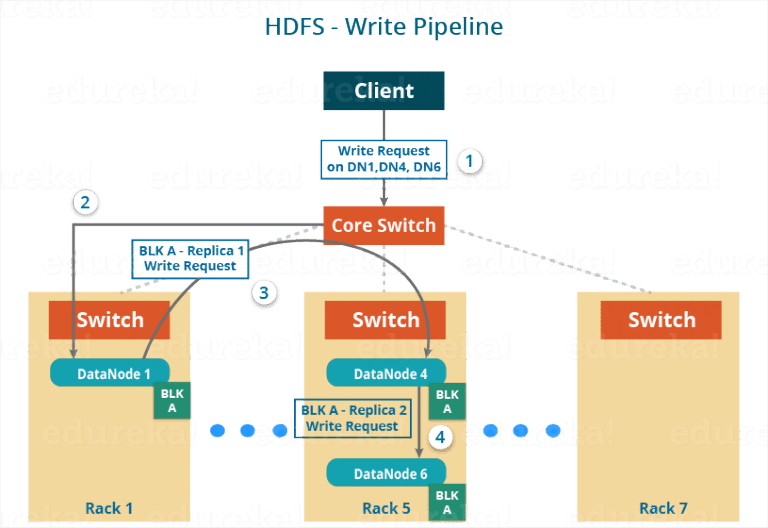

Отже, під час реплікації відбуватимуться наступні кроки:

- Після того як клієнт записав блок у DataNode 1, DataNode 1 підключиться до DataNode 4.

- Потім DataNode 1 надішле блок у конвеєр, і дані будуть скопійовані до DataNode 4.

- Аналогічно, DataNode 4 підключиться до DataNode 6 і скопіює останню репліку блоку.

*Завершення роботи конвеєра*:

Після того, як блок буде скопійовано в усі три DataNodes, відбудеться серія підтверджень, щоб переконатися, що клієнт і NameNode успішно записали дані. Потім клієнт остаточно закриє конвеєр, щоб завершити сеанс TCP.

Як показано на рисунку нижче, підтвердження відбувається у зворотній послідовності, тобто від DataNode 6 до 4, а потім до 1. Нарешті, DataNode 1 передасть три підтвердження (включно з власним) у конвеєр і надішле його клієнту. Клієнт повідомить NameNode, що дані були успішно записані. NameNode оновить свої метадані, а клієнт закриє конвеєр.

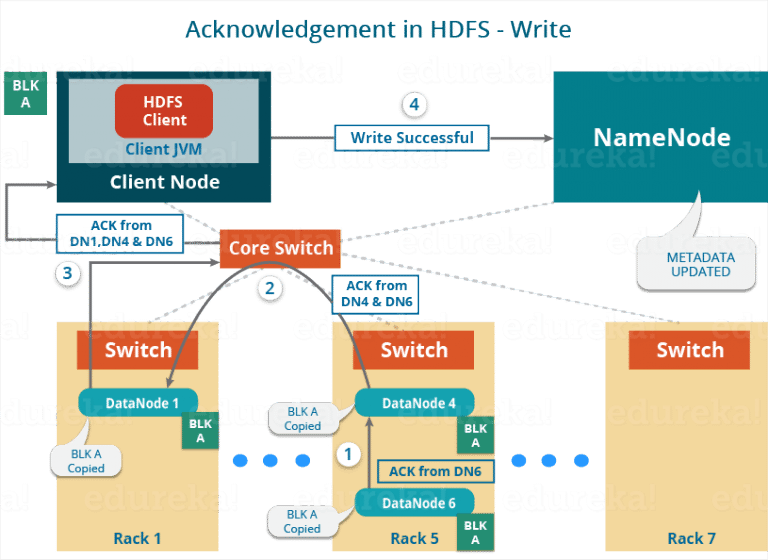

Подібним чином, буде скопійовано в DataNodes блок B паралельно з блоком A. Отже, варто звернути увагу на наступне:

- Клієнт копіюватиме блок A і блок B до першого DataNode одночасно.

- Отже, у нашому випадку для кожного блоку буде сформовано два конвеєри, і весь процес, розглянутий вище, відбуватиметься паралельно в цих двох конвеєрах.

- Клієнт записує блок у перший DataNode, а потім DataNodes послідовно копіюватимуть блок.

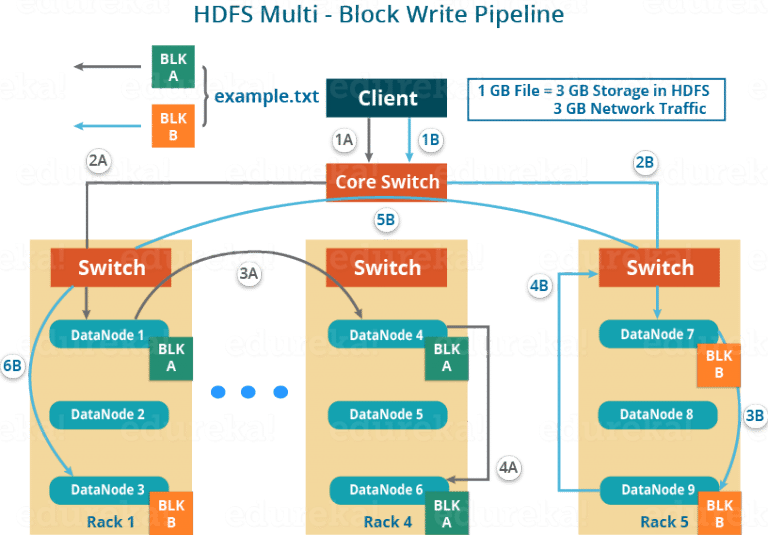

Як відображено на рисунку, для кожного блоку (A і B) сформовано два конвеєри. Нижче наведено послідовність операцій, які виконуються для кожного блоку у відповідних конвеєрах:

- Для блоку A: `1A -> 2A -> 3A -> 4A`

- Для блоку B: `1B -> 2B -> 3B -> 4B -> 5B -> 6B` 

**Читання в HDFS**:

Розглянемо знову наведений вище приклад, де клієнт HDFS тепер хоче прочитати файл *example.txt*.

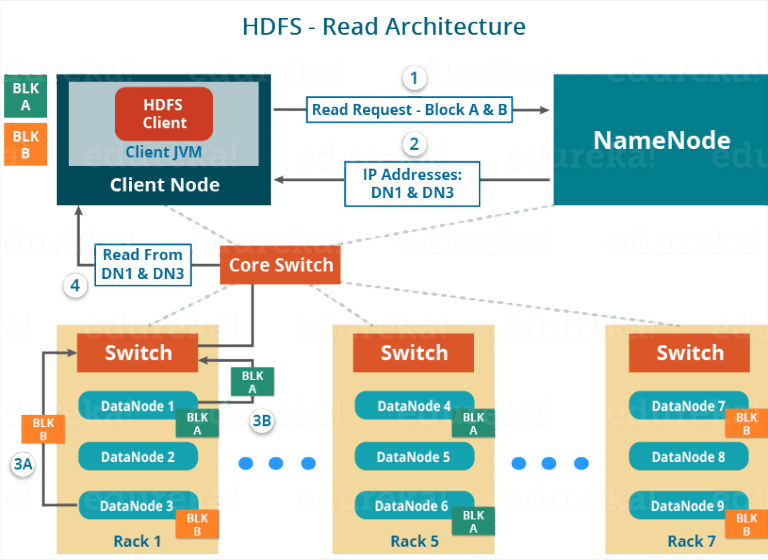

Під час читання файлу виконуються такі кроки:

- Клієнт звертається до NameNode із запитом про метадані стосовно блоків для файлу *example.txt*.

- NameNode повертає список DataNodes, де зберігається кожен блок (блоки A і B).

- Клієнт під'єднується до відповідних DataNodes та паралельно зчитує з них дані (блок A з DataNode 1 і блок B з DataNode 3).

- Клієнт об’єднує всі отримані блоки, щоб сформувати файл.

HDFS вибирає репліку, яка є найближчою до клієнта, що зменшує затримку читання та об'єми використовуваного трафіку. Тобто, вибирається та репліка, яка знаходиться у тій самій стійці, що й вузол читання, якщо це можливо.